# Load all necessary frameworks

In [57]:
# Standard frameworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

# Frameworks for data collection
import json
import requests

# Frameworks for machine learning model creation
from keras.models import Sequential, load_model
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

# DASH frameworks for dashboard view creation
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
from dash.dependencies import Input, Output

## 1. BTC Market data preparation and analysis

### 1.1 Data preparation

In [58]:
# Loading the data
source = 'https://min-api.cryptocompare.com/data/v2/histoday'
res = requests.get(source + '?fsym=BTC&tsym=USD&limit=1234')
df_BTC = pd.DataFrame(json.loads(res.content)['Data']['Data']) # Select the Data column in the Array that is inside an Object called data
df_BTC = df_BTC.set_index('time')
df_BTC.index = pd.to_datetime(df_BTC.index, unit='s')

In [59]:
# Resset The index of the dataframe
df_BTC.reset_index(inplace = True)

In [60]:
# Rename the columns of the dataframe for compatibility
df_BTC = df_BTC.rename(columns = {"time":"Date","high":"High","low":"Low", "open":"Open", "volumeto":"Total Trade Quantity","close":"Close"})

In [61]:
# Drop unused columns
df_BTC = df_BTC.drop(['volumefrom', 'conversionType', 'conversionSymbol'], axis=1)

In [62]:
# Reorder the columns in the dataframe
df_BTC=df_BTC.reindex(columns= ['Date', 'Open', 'High','Low', 'Close', 'Total Trade Quantity'])

In [63]:
# Check out the dataset with the top 5 results
df_BTC.head()

,Date,Open,High,Low,Close,Total Trade Quantity
0,2018-01-06,16954.76,17252.85,16286.57,17172.30,1.412704e+09
1,2018-01-07,17174.50,17184.81,15791.13,16228.16,1.309533e+09
2,2018-01-08,16228.26,16302.92,13902.31,14976.17,2.166367e+09
3,2018-01-09,14976.17,15390.28,14221.55,14468.50,1.486802e+09
4,2018-01-10,14468.09,14919.49,13450.54,14919.49,2.025084e+09


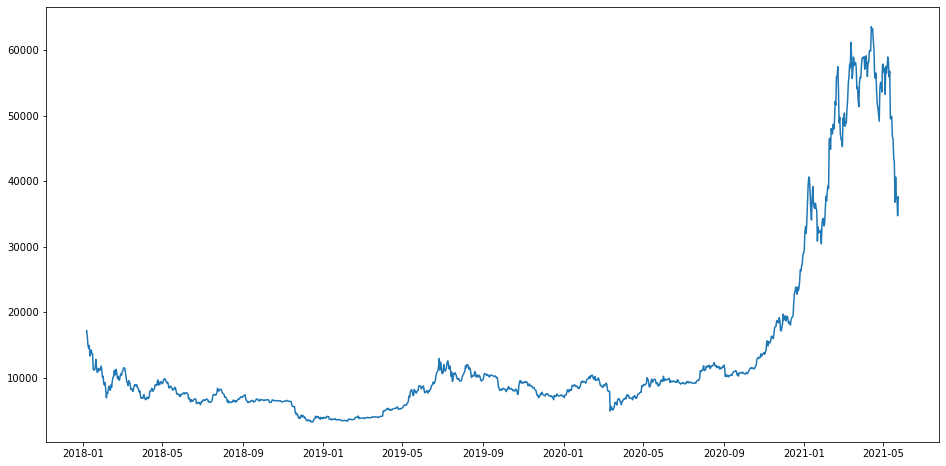

In [64]:
# Checkout the distribution of the dataset in a plot
df_BTC["Date"]=pd.to_datetime(df_BTC.Date,format="%Y-%m-%d")
df_BTC.index=df_BTC['Date']

plt.figure(figsize=(16,8))
plt.plot(df_BTC["Close"],label='Close Price history')

In [65]:
# Sort the dataset by the date column
data_BTC = df_BTC.sort_index(ascending = True,axis=0)
new_dataset_BTC = pd.DataFrame(index = range(0,len(df_BTC)), columns = ['Date','Close'])

for i in range(0,len(data_BTC)):
    new_dataset_BTC["Date"][i] = data_BTC['Date'][i]
    new_dataset_BTC["Close"][i] = data_BTC["Close"][i]

### 1.2 Normalize the BTC dataset

In [66]:
# Introduce the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
final_dataset_BTC = new_dataset_BTC.values

train_data_BTC = final_dataset_BTC[0:987,:]
valid_data_BTC = final_dataset_BTC[987:,:]

In [67]:
new_dataset_BTC.index = new_dataset_BTC.Date

In [68]:
new_dataset_BTC.drop("Date",axis=1,inplace=True)

In [69]:
scaled_data_BTC = scaler.fit_transform(new_dataset_BTC)

In [70]:
x_train_data_BTC, y_train_data_BTC = [],[]

for i in range(60,len(train_data_BTC)):
    x_train_data_BTC.append(scaled_data_BTC[i-60:i,0])
    y_train_data_BTC.append(scaled_data_BTC[i,0])
    
x_train_data_BTC, y_train_data_BTC = np.array(x_train_data_BTC), np.array(y_train_data_BTC)

x_train_data_BTC = np.reshape(x_train_data_BTC, (x_train_data_BTC.shape[0], x_train_data_BTC.shape[1], 1))

### 1.3 Build and train the LSTM model for BTC:

In [71]:
lstm_model_BTC = Sequential()
lstm_model_BTC.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train_data_BTC.shape[1], 1)))
lstm_model_BTC.add(LSTM(units = 50))
lstm_model_BTC.add(Dense(1))

inputs_data_BTC = new_dataset_BTC[len(new_dataset_BTC) - len(valid_data_BTC) - 60:].values
inputs_data_BTC = inputs_data_BTC.reshape(-1, 1)
inputs_data_BTC = scaler.transform(inputs_data_BTC)

lstm_model_BTC.compile(loss='mean_squared_error',optimizer='adam')
lstm_model_BTC.fit(x_train_data_BTC, y_train_data_BTC, epochs = 1, batch_size = 1, verbose = 2)

927/927 - 45s - loss: 2.0172e-04


### 1.4 Take a sample of the dataset to do price predictions using the LSTM model for BTC:

In [72]:
X_test_BTC = []
for i in range(60,inputs_data_BTC.shape[0]):
    X_test_BTC.append(inputs_data_BTC[i-60:i, 0])
X_test_BTC = np.array(X_test_BTC)

X_test_BTC = np.reshape(X_test_BTC, (X_test_BTC.shape[0], X_test_BTC.shape[1], 1))
predicted_closing_price_BTC = lstm_model_BTC.predict(X_test_BTC)
predicted_closing_price_BTC = scaler.inverse_transform(predicted_closing_price_BTC)

### 1.5 Save the BTC LSTM model

In [73]:
lstm_model_BTC.save("LSTM_BTC_model.h5")

### 1.6 See the predicted and the test values in a plot

<ipython-input-74-cbdc09584b01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data_BTC['Predictions']=predicted_closing_price_BTC


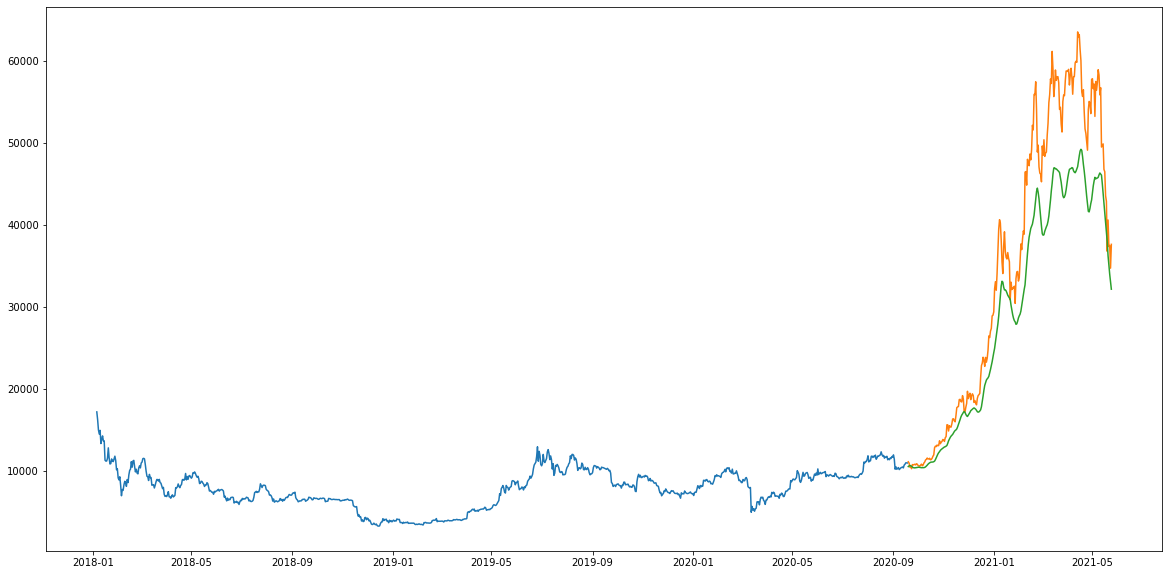

In [74]:
train_data_BTC = new_dataset_BTC[:987]
valid_data_BTC = new_dataset_BTC[987:]
valid_data_BTC['Predictions']=predicted_closing_price_BTC
plt.plot(train_data_BTC["Close"])
plt.plot(valid_data_BTC[['Close',"Predictions"]])

## 2. NASDAQ Market data preparation and analysis

### 2.1 Data preparation

In [75]:
NASDAQ_data_source = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/^NDX?apikey={"73467244dfdaa6fe164d0898aac16d12"}').json()
NASDAQ_data = NASDAQ_data_source['historical']

In [76]:
#add each of the historical prices into a dictionary and store it as a DF
hist_Prices= {}
for item in NASDAQ_data:
  date_Etf = item['date']
  hist_Prices[date_Etf] = item

NASDAQ_df= pd.DataFrame.from_dict(hist_Prices,orient='index')
NASDAQ_df.reset_index(inplace=True)
NASDAQ_df = NASDAQ_df.head(n=1235) # Select the last 1234 rows

In [77]:
# Drop unused columns
NASDAQ_df = NASDAQ_df.drop(['index', 'adjClose', 'volume', 'unadjustedVolume', 'change', 'changePercent', 'vwap', 'label', 'changeOverTime'], axis=1)

In [78]:
# Rename the columns of the dataframe for compatibility
NASDAQ_df = NASDAQ_df.rename(columns = {"date":"Date", "open":"Open", "high":"High", "low":"Low", "close":"Close"})

In [79]:
NASDAQ_df.head()

,Date,Open,High,Low,Close
0,2021-05-21,13573.219727,13573.839844,13401.530273,13411.740234
1,2021-05-20,13294.589844,13526.009766,13293.099609,13494.089844
2,2021-05-19,12998.530273,13243.980469,12994.349609,13237.910156
3,2021-05-18,13352.259766,13400.519531,13212.849609,13217.679688
4,2021-05-17,13329.860352,13350.139648,13196.570313,13312.910156


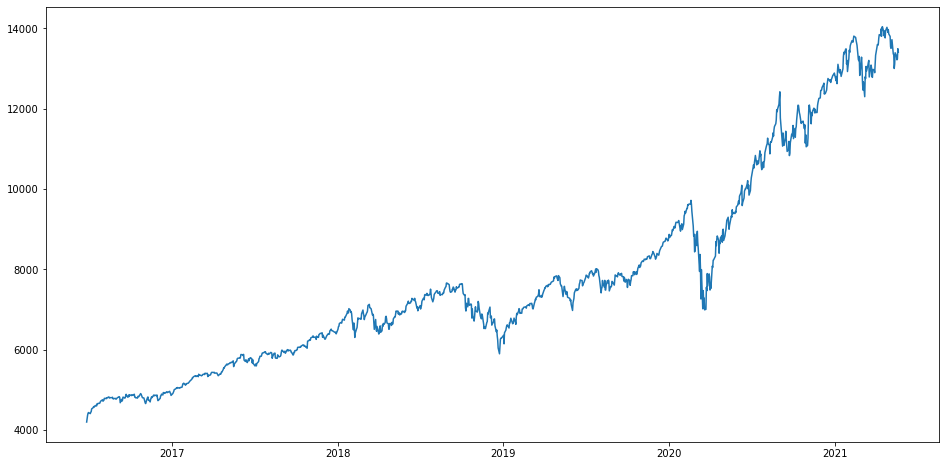

In [80]:
# Checkout the distribution of the dataset in a plot
NASDAQ_df["Date"] = pd.to_datetime(NASDAQ_df.Date, format = "%Y-%m-%d")
NASDAQ_df.index = NASDAQ_df['Date']

plt.figure(figsize = (16,8))
plt.plot(NASDAQ_df["Close"], label = "Close Price History")

In [81]:
# Sort the data by the date column
data_NASDAQ = NASDAQ_df.sort_index(ascending = True,axis=0)
new_dataset_NASDAQ = pd.DataFrame(index = range(0,len(NASDAQ_df)), columns = ['Date','Close'])

for i in range(0,len(data_NASDAQ)):
    new_dataset_NASDAQ["Date"][i] = data_NASDAQ['Date'][i]
    new_dataset_NASDAQ["Close"][i] = data_NASDAQ["Close"][i]

### 2.2 Normalize the BTC dataset

In [82]:
final_dataset_NASDAQ = new_dataset_NASDAQ.values

train_data_NASDAQ = final_dataset_NASDAQ[0:987,:]
valid_data_NASDAQ = final_dataset_NASDAQ[987:,:]

new_dataset_NASDAQ.index = new_dataset_NASDAQ.Date

new_dataset_NASDAQ.drop("Date",axis=1,inplace=True)

scaled_data_NASDAQ = scaler.fit_transform(new_dataset_NASDAQ)

In [83]:
x_train_data_NASDAQ, y_train_data_NASDAQ = [],[]

for i in range(60,len(train_data_NASDAQ)):
    x_train_data_NASDAQ.append(scaled_data_NASDAQ[i-60:i,0])
    y_train_data_NASDAQ.append(scaled_data_NASDAQ[i,0])
    
x_train_data_NASDAQ, y_train_data_NASDAQ = np.array(x_train_data_NASDAQ), np.array(y_train_data_NASDAQ)

x_train_data_NASDAQ = np.reshape(x_train_data_NASDAQ, (x_train_data_NASDAQ.shape[0], x_train_data_NASDAQ.shape[1], 1))

### 2.3 Build and train the LSTM model for BTC

In [84]:
lstm_model_NASDAQ = Sequential()
lstm_model_NASDAQ.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train_data_NASDAQ.shape[1], 1)))
lstm_model_NASDAQ.add(LSTM(units = 50))
lstm_model_NASDAQ.add(Dense(1))

inputs_data_NASDAQ = new_dataset_NASDAQ[len(new_dataset_NASDAQ) - len(valid_data_NASDAQ) - 60:].values
inputs_data_NASDAQ = inputs_data_NASDAQ.reshape(-1, 1)
inputs_data_NASDAQ = scaler.transform(inputs_data_NASDAQ)

lstm_model_NASDAQ.compile(loss='mean_squared_error',optimizer='adam')
lstm_model_NASDAQ.fit(x_train_data_NASDAQ, y_train_data_NASDAQ, epochs = 1, batch_size = 1, verbose = 2)

927/927 - 45s - loss: 9.1010e-04


### 2.4 Take a sample of a dataset to price predictions using the LSTM model for BTC:

In [85]:
X_test_NASDAQ = []
for i in range(60,inputs_data_NASDAQ.shape[0]):
    X_test_NASDAQ.append(inputs_data_NASDAQ[i-60:i, 0])
X_test_NASDAQ = np.array(X_test_NASDAQ)

X_test_NASDAQ = np.reshape(X_test_NASDAQ, (X_test_NASDAQ.shape[0], X_test_NASDAQ.shape[1], 1))
predicted_closing_price_NASDAQ = lstm_model_NASDAQ.predict(X_test_NASDAQ)
predicted_closing_price_NASDAQ = scaler.inverse_transform(predicted_closing_price_NASDAQ)

### 2.5 Save the BTC LSTM model

In [86]:
lstm_model_BTC.save("LSTM_NASDAQ_model.h5")

### 2.6 See the predicted and the test values in a plot

<ipython-input-87-360d74e5f1f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data_NASDAQ['Predictions']=predicted_closing_price_NASDAQ


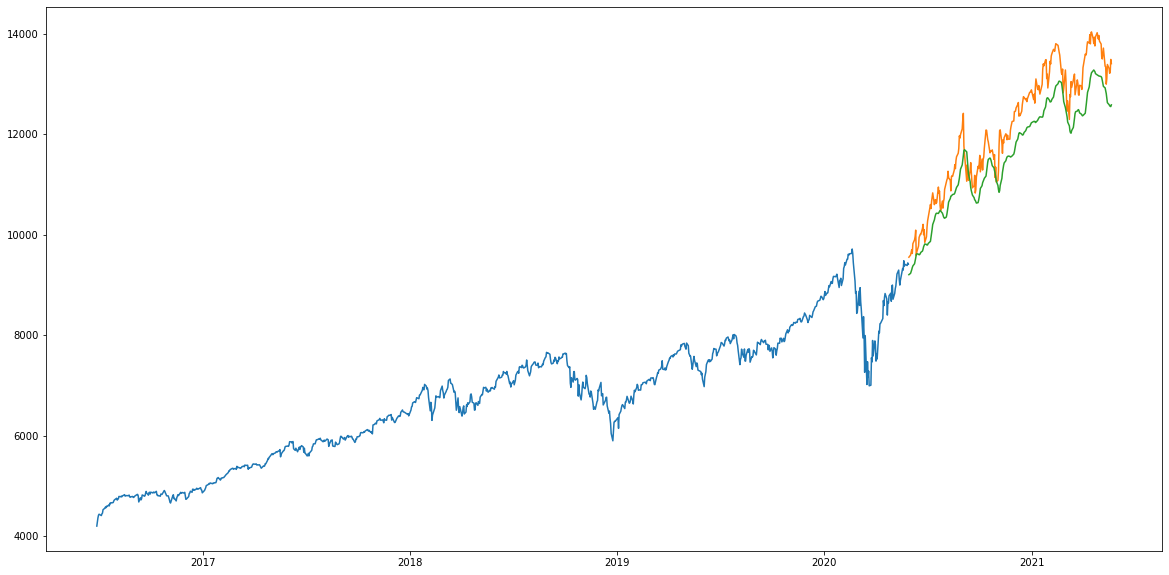

In [87]:
train_data_NASDAQ = new_dataset_NASDAQ[:987]
valid_data_NASDAQ = new_dataset_NASDAQ[987:]
valid_data_NASDAQ['Predictions']=predicted_closing_price_NASDAQ
plt.plot(train_data_NASDAQ["Close"])
plt.plot(valid_data_NASDAQ[['Close',"Predictions"]])

## 3. SNP500 Market data preparation and analysis

### 3.1 Data Preparation

In [88]:
SNP_data_source = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/^GSPC?apikey={"73467244dfdaa6fe164d0898aac16d12"}').json()
SNP_data = SNP_data_source['historical']

#add each of the historical prices into a dictionary and store it as a DF
hist_Prices= {}
for item in SNP_data:
  date_Etf = item['date']
  hist_Prices[date_Etf] = item

SNP_df= pd.DataFrame.from_dict(hist_Prices,orient='index')
SNP_df.reset_index(inplace=True)
SNP_df = SNP_df.head(n=1235) # Select the last 1234 rows

In [89]:
# Drop unused columns
SNP_df = SNP_df.drop(['index', 'adjClose', 'volume', 'unadjustedVolume', 'change', 'changePercent', 'vwap', 'label', 'changeOverTime'], axis=1)

In [90]:
# Rename the columns of the dataframe for compatibility
SNP_df = SNP_df.rename(columns = {"date":"Date", "open":"Open", "high":"High", "low":"Low", "close":"Close"})

In [91]:
SNP_df.head()

,Date,Open,High,Low,Close
0,2021-05-21,4168.609863,4188.720215,4151.720215,4155.859863
1,2021-05-20,4121.970215,4172.799805,4121.970215,4159.120117
2,2021-05-19,4098.450195,4116.930176,4061.409912,4115.680176
3,2021-05-18,4165.939941,4169.149902,4125.990234,4127.830078
4,2021-05-17,4169.919922,4171.919922,4142.689941,4163.290039


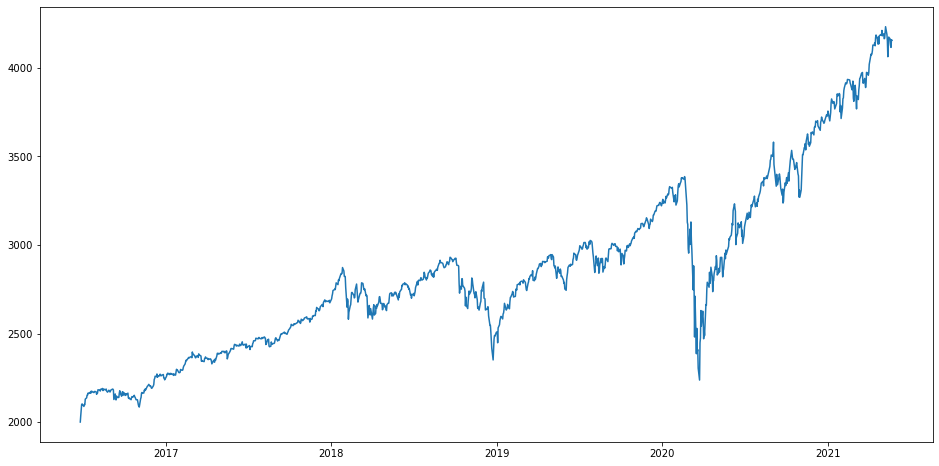

In [92]:
# Checkout the distribution of the dataset in a plot
SNP_df["Date"] = pd.to_datetime(SNP_df.Date, format = "%Y-%m-%d")
SNP_df.index = SNP_df['Date']
plt.figure(figsize = (16,8))
plt.plot(SNP_df["Close"], label = "Close Price History")

In [93]:
# Sort the data by the date column
data_SNP = SNP_df.sort_index(ascending = True,axis=0)
new_dataset_SNP = pd.DataFrame(index = range(0,len(SNP_df)), columns = ['Date','Close'])

for i in range(0,len(data_SNP)):
    new_dataset_SNP["Date"][i] = data_SNP['Date'][i]
    new_dataset_SNP["Close"][i] = data_SNP["Close"][i]

### 3.2 Normalize the SNP500 dataset

In [94]:
final_dataset_SNP = new_dataset_SNP.values

train_data_SNP = final_dataset_SNP[0:987,:]
valid_data_SNP = final_dataset_SNP[987:,:]

new_dataset_SNP.index = new_dataset_SNP.Date

new_dataset_SNP.drop("Date",axis=1,inplace=True)

scaled_data_SNP = scaler.fit_transform(new_dataset_SNP)

In [95]:
x_train_data_SNP, y_train_data_SNP = [],[]

for i in range(60,len(train_data_SNP)):
    x_train_data_SNP.append(scaled_data_SNP[i-60:i,0])
    y_train_data_SNP.append(scaled_data_SNP[i,0])
    
x_train_data_SNP, y_train_data_SNP = np.array(x_train_data_SNP), np.array(y_train_data_SNP)

x_train_data_SNP = np.reshape(x_train_data_SNP, (x_train_data_SNP.shape[0], x_train_data_SNP.shape[1], 1))

### 3.3 Build and train the LSTM model for SNP500

In [96]:
lstm_model_SNP = Sequential()
lstm_model_SNP.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train_data_SNP.shape[1], 1)))
lstm_model_SNP.add(LSTM(units = 50))
lstm_model_SNP.add(Dense(1))

inputs_data_SNP = new_dataset_SNP[len(new_dataset_SNP) - len(valid_data_SNP) - 60:].values
inputs_data_SNP = inputs_data_SNP.reshape(-1, 1)
inputs_data_SNP = scaler.transform(inputs_data_SNP)

lstm_model_SNP.compile(loss='mean_squared_error',optimizer='adam')
lstm_model_SNP.fit(x_train_data_SNP, y_train_data_SNP, epochs = 1, batch_size = 1, verbose = 2)

927/927 - 44s - loss: 0.0015


### 3.4 Take a sample of a dataset to price prediction using the LSTM model for SNP500

In [97]:
X_test_SNP = []
for i in range(60,inputs_data_SNP.shape[0]):
    X_test_SNP.append(inputs_data_SNP[i-60:i, 0])
X_test_SNP = np.array(X_test_SNP)

X_test_SNP = np.reshape(X_test_SNP, (X_test_SNP.shape[0], X_test_SNP.shape[1], 1))
predicted_closing_price_SNP = lstm_model_SNP.predict(X_test_SNP)
predicted_closing_price_SNP = scaler.inverse_transform(predicted_closing_price_SNP)

### 3.5 Save the SNP500 LSTM model

In [98]:
lstm_model_BTC.save("LSTM_SNP500_model.h5")

### 3.6 See the predicted and the test values in a plot

<ipython-input-99-e00faab437c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data_SNP['Predictions']=predicted_closing_price_SNP


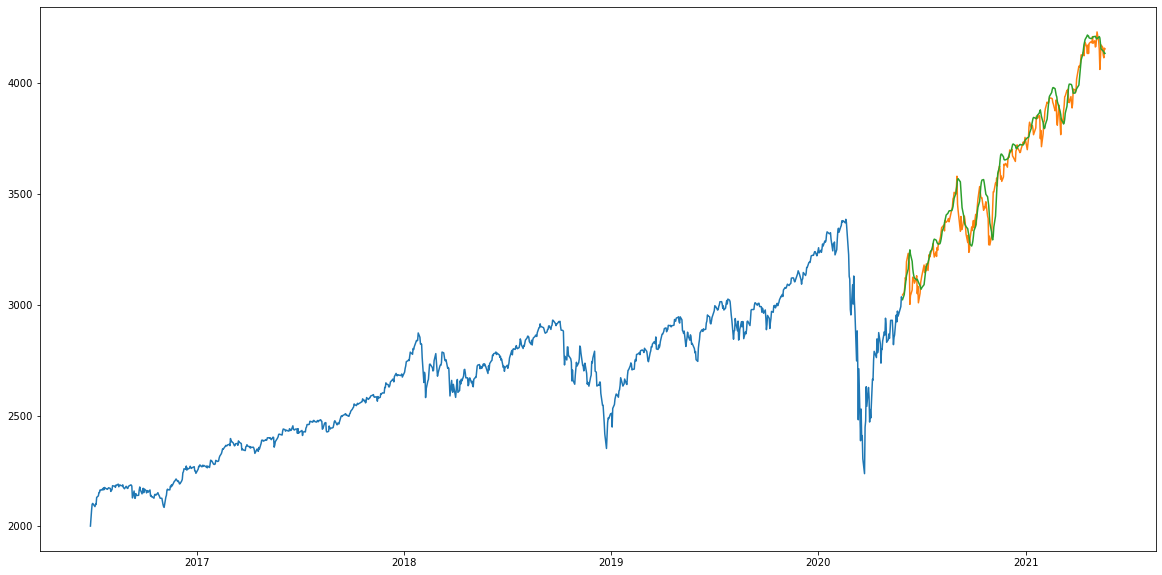

In [99]:
train_data_SNP = new_dataset_SNP[:987]
valid_data_SNP = new_dataset_SNP[987:]
valid_data_SNP['Predictions']=predicted_closing_price_SNP
plt.plot(train_data_SNP["Close"])
plt.plot(valid_data_SNP[['Close',"Predictions"]])

# Build the dashboard using Plotly dash

In [100]:
###### Introducing SnP, NasDaq, BTC in different tabs 
app = dash.Dash()
server = app.server

scaler=MinMaxScaler(feature_range=(0,1))


############### BTC dataset operations ##########################################################################
df_BTC["Date"] = pd.to_datetime(df_BTC.Date,format="%Y-%m-%d")
df_BTC.index=df_BTC['Date']

data_BTC = df_BTC.sort_index(ascending=True, axis=0)
new_data_BTC = pd.DataFrame(index=range(0,len(df_BTC)), columns=['Date','Close'])

for i in range(0,len(data_BTC)):
    new_data_BTC["Date"][i]=data_BTC['Date'][i]
    new_data_BTC["Close"][i]=data_BTC["Close"][i]

new_data_BTC.index = new_data_BTC.Date
new_data_BTC.drop("Date", axis=1, inplace=True)

dataset_BTC = new_data_BTC.values

train_BTC = dataset_BTC[0:987,:]
valid_BTC = dataset_BTC[987:,:]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_BTC = scaler.fit_transform(dataset_BTC)

x_train_BTC, y_train_BTC = [],[]

for i in range(60,len(train_BTC)):
    x_train_BTC.append(scaled_data_BTC[i-60:i,0])
    y_train_BTC.append(scaled_data_BTC[i,0])
    
x_train_BTC, y_train_BTC = np.array(x_train_BTC),np.array(y_train_BTC)

x_train_BTC = np.reshape(x_train_BTC, (x_train_BTC.shape[0], x_train_BTC.shape[1],1))

model_BTC = load_model("LSTM_BTC_model.h5")

inputs_BTC = new_data_BTC[len(new_data_BTC)-len(valid_BTC)-60:].values
inputs_BTC = inputs_BTC.reshape(-1,1)
inputs_BTC = scaler.transform(inputs_BTC)

X_test_BTC = []
for i in range(60,inputs_BTC.shape[0]):
    X_test_BTC.append(inputs_BTC[i-60:i,0])

X_test_BTC = np.array(X_test_BTC)

X_test_BTC = np.reshape(X_test_BTC, (X_test_BTC.shape[0], X_test_BTC.shape[1],1))
closing_price_BTC = model_BTC.predict(X_test_BTC)
closing_price_BTC = scaler.inverse_transform(closing_price_BTC)

train_BTC = new_data_BTC[:987]
valid_BTC = new_data_BTC[987:]
valid_BTC['Predictions'] = closing_price_BTC


############### NASDAQ dataset operations ##########################################################################
NASDAQ_df["Date"] = pd.to_datetime(NASDAQ_df.Date,format="%Y-%m-%d")
NASDAQ_df.index=NASDAQ_df['Date']

data_NASDAQ = NASDAQ_df.sort_index(ascending=True, axis=0)
new_data_NASDAQ = pd.DataFrame(index=range(0,len(NASDAQ_df)), columns=['Date','Close'])

for i in range(0,len(data_NASDAQ)):
    new_data_NASDAQ["Date"][i]=data_NASDAQ['Date'][i]
    new_data_NASDAQ["Close"][i]=data_NASDAQ["Close"][i]

new_data_NASDAQ.index = new_data_NASDAQ.Date
new_data_NASDAQ.drop("Date", axis=1, inplace=True)

dataset_NASDAQ = new_data_NASDAQ.values

train_NASDAQ = dataset_NASDAQ[0:987,:]
valid_NASDAQ = dataset_NASDAQ[987:,:]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_NASDAQ = scaler.fit_transform(dataset_NASDAQ)

x_train_NASDAQ, y_train_NASDAQ = [],[]

for i in range(60,len(train_NASDAQ)):
    x_train_NASDAQ.append(scaled_data_NASDAQ[i-60:i,0])
    y_train_NASDAQ.append(scaled_data_NASDAQ[i,0])
    
x_train_NASDAQ, y_train_NASDAQ = np.array(x_train_NASDAQ),np.array(y_train_NASDAQ)

x_train_NASDAQ = np.reshape(x_train_NASDAQ, (x_train_NASDAQ.shape[0], x_train_NASDAQ.shape[1],1))

model_NASDAQ = load_model("LSTM_NASDAQ_model.h5")


inputs_NASDAQ = new_data_NASDAQ[len(new_data_NASDAQ)-len(valid_NASDAQ)-60:].values
inputs_NASDAQ = inputs_NASDAQ.reshape(-1,1)
inputs_NASDAQ = scaler.transform(inputs_NASDAQ)

X_test_NASDAQ = []
for i in range(60,inputs_NASDAQ.shape[0]):
    X_test_NASDAQ.append(inputs_NASDAQ[i-60:i,0])

X_test_NASDAQ = np.array(X_test_NASDAQ)

X_test_NASDAQ = np.reshape(X_test_NASDAQ, (X_test_NASDAQ.shape[0], X_test_NASDAQ.shape[1],1))
closing_price_NASDAQ = model_NASDAQ.predict(X_test_NASDAQ)
closing_price_NASDAQ = scaler.inverse_transform(closing_price_NASDAQ)

train_NASDAQ = new_data_NASDAQ[:987]
valid_NASDAQ = new_data_NASDAQ[987:]
valid_NASDAQ['Predictions'] = closing_price_NASDAQ


############### SNP500 dataset operations ##########################################################################
SNP_df["Date"] = pd.to_datetime(SNP_df.Date,format="%Y-%m-%d")
SNP_df.index=SNP_df['Date']

data_SNP = SNP_df.sort_index(ascending=True, axis=0)
new_data_SNP = pd.DataFrame(index=range(0,len(SNP_df)), columns=['Date','Close'])

for i in range(0,len(data_SNP)):
    new_data_SNP["Date"][i]=data_SNP['Date'][i]
    new_data_SNP["Close"][i]=data_SNP["Close"][i]

new_data_SNP.index = new_data_SNP.Date
new_data_SNP.drop("Date", axis=1, inplace=True)

dataset_SNP = new_data_SNP.values

train_SNP = dataset_SNP[0:987,:]
valid_SNP = dataset_SNP[987:,:]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_SNP = scaler.fit_transform(dataset_SNP)

x_train_SNP, y_train_SNP = [],[]

for i in range(60,len(train_SNP)):
    x_train_SNP.append(scaled_data_SNP[i-60:i,0])
    y_train_SNP.append(scaled_data_SNP[i,0])
    
x_train_SNP, y_train_SNP = np.array(x_train_SNP),np.array(y_train_SNP)

x_train_SNP = np.reshape(x_train_SNP, (x_train_SNP.shape[0], x_train_SNP.shape[1],1))

model_SNP = load_model("LSTM_SNP500_model.h5")


inputs_SNP = new_data_SNP[len(new_data_SNP)-len(valid_SNP)-60:].values
inputs_SNP = inputs_SNP.reshape(-1,1)
inputs_SNP = scaler.transform(inputs_SNP)

X_test_SNP = []
for i in range(60,inputs_SNP.shape[0]):
    X_test_SNP.append(inputs_SNP[i-60:i,0])

X_test_SNP = np.array(X_test_SNP)

X_test_SNP = np.reshape(X_test_SNP, (X_test_SNP.shape[0], X_test_SNP.shape[1],1))
closing_price_SNP = model_SNP.predict(X_test_SNP)
closing_price_SNP = scaler.inverse_transform(closing_price_SNP)

train_SNP = new_data_SNP[:987]
valid_SNP = new_data_SNP[987:]
valid_SNP['Predictions'] = closing_price_SNP



#################### Tabs in the UI ######################

app.layout = html.Div([
   
    html.H1("Stock Price Analysis Dashboard", style={"textAlign": "center"}),
   
    dcc.Tabs(id="tabs", children=[
        
        ################ BTC tab ####################
        dcc.Tab(label='BTC',children=[
            html.Div([
                html.H2("BTC Historical Closing Price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="BTC Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid_BTC.index,
                                y=valid_BTC["Close"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                ),
                html.H2("BTC Predicted Closing Price Using LSTM",style={"textAlign": "center"}),
                dcc.Graph(
                    id="BTC Perdicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid_BTC.index,
                                y=valid_BTC["Predictions"],
                                mode='markers'
                            )

                        ],
                        "layout":go.Layout(
                            title='',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                )                
            ])                
        ]),
        
        
        
        ################ NASDAQ tab ####################
        dcc.Tab(label='NASDAQ',children=[
            html.Div([
                html.H2("NASDAQ Historical Closing Price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="NASDAQ Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid_NASDAQ.index,
                                y=valid_NASDAQ["Close"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                ),
                html.H2("NASDAQ Predicted Closing Price Using LSTM",style={"textAlign": "center"}),
                dcc.Graph(
                    id="NASDAQ Perdicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid_NASDAQ.index,
                                y=valid_NASDAQ["Predictions"],
                                mode='markers'
                            )

                        ],
                        "layout":go.Layout(
                            title='',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                )                
            ])                
        ]),
        
        
        
        ################ SNP500 tab ####################
        dcc.Tab(label='SNP500',children=[
            html.Div([
                html.H2("SNP500 Historical Closing Price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="SNP500 Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid_SNP.index,
                                y=valid_SNP["Close"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                ),
                html.H2("SNP500 Predicted Closing Price Using LSTM",style={"textAlign": "center"}),
                dcc.Graph(
                    id="SNP500 Perdicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid_SNP.index,
                                y=valid_SNP["Predictions"],
                                mode='markers'
                            )

                        ],
                        "layout":go.Layout(
                            title='',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                )                
            ])                
        ])


    ])
])

<ipython-input-100-fc23fbcea45e>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_BTC['Predictions'] = closing_price_BTC
<ipython-input-100-fc23fbcea45e>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_NASDAQ['Predictions'] = closing_price_NASDAQ
<ipython-input-100-fc23fbcea45e>:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [101]:
# If debug = True for jupyter it makes problems
#if __name__=='__main__':
#    app.run_server(debug=True)
    
if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [24/May/2021 16:30:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/May/2021 16:30:35] "GET /_favicon.ico?v=1.20.0 HTTP/1.1" 200 -
127.0.0.1 - - [24/May/2021 16:30:35] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [24/May/2021 16:30:35] "GET /_dash-layout HTTP/1.1" 200 -
